## 소설 문장 분류 프로젝트
### 데이터셋 소개
* 소설의 대표적인 문장과 그 문장을 작성한 작가로 이루어진 데이터셋 입니다.
* 작가는 원본 데이터셋에서도 비식별화 처리가 되어있습니다. 따라서 index 형태로 제공됩니다.
* 작가는 총 5명 입니다.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

### Data load

In [2]:
train_data = pd.read_csv('data/novel/novel_train_data.csv')
test_data = pd.read_csv('data/novel/novel_test_data.csv')

* train dataset : 43,903
* test dataset : 10,976

In [3]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43903 entries, 0 to 43902
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   43903 non-null  int64 
 1   text    43903 non-null  object
 2   author  43903 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10976 entries, 0 to 10975
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   10976 non-null  int64 
 1   text    10976 non-null  object
 2   author  10976 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 257.4+ KB


In [4]:
train_data.head()

,index,text,author
0,12154,The relations between odin Stone and the notor...,2
1,8376,"She sat immovable beside me; but, again I saw ...",0
2,45045,"The besiegers, appalled by their own riot and ...",4
3,45769,"“PERICOLO—pericolo—eh, what’s that, odin? ‘Dan...",2
4,14354,"“odin is a clever fellow,” said he. “How do yo...",2


In [5]:
test_data.head()

,index,text,author
0,34282,“Of course after that there was nothing more t...,1
1,47847,"“It is a very fine lass,” he said at last. “od...",4
2,47381,"Captain odin, however, came from his window, a...",1
3,39571,"odin was immediately taken away, and locked up...",0
4,52923,"“At the first glimpse of the rising sun, princ...",3


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preprocessing
* 주어진 데이터를 index 형태로 변경한 후 vocab을 제작해야합니다.
* 먼저, 학습용 데이터와 정답 데이터를 먼저 분리합니다.
* 분리된 학습용 데이터를 index화, vocab을 제작합니다.
* 이후 데이터로더를 이용해서 데이터 파이프라인을 완성합니다.
* train, test 데이터 모두 데이터로더로 제작합니다.

In [7]:
# 기본 영어 토크나이저 초기화
tokenizer = get_tokenizer("basic_english")
tokenized_texts = []
labels = []
for i,s,a in train_data.values:
    tokenized_texts.append(tokenizer(s))
    labels.append(a)

test_tokenized_texts = []
test_labels = []
for i,s,a in test_data.values:
    test_tokenized_texts.append(tokenizer(s))
    test_labels.append(a)
    
print(len(tokenized_texts), len(test_tokenized_texts))

43903 10976


In [8]:
from collections import Counter


def build_vocab_with_padding_and_unk(tokenized_texts, padding_token='<pad>', unk_token='<unk>'):
    # 모든 토큰의 빈도수를 계산합니다.
    token_freqs = Counter(token for text in tokenized_texts for token in text)

    # 어휘 사전을 구축합니다. padding_token과 unk_token을 각각 0번, 1번 인덱스에 추가합니다.
    vocab = {padding_token: 0, unk_token: 1}
    vocab.update({token: idx + 2 for idx, (token, _) in enumerate(token_freqs.items())})

    return vocab

In [9]:
all_tokenized_text = tokenized_texts + test_tokenized_texts
vocab = build_vocab_with_padding_and_unk(all_tokenized_text)
len(vocab)

52400

In [10]:
list(vocab.items())[0]

('<pad>', 0)

In [11]:
vocab = dict(list(vocab.items())[:50000])
len(vocab)

50000

In [12]:
def tokenize_and_index(texts, vocab):
    indexed_texts = []
    for text in texts:
        indexed_text = [vocab[token] if token in vocab else vocab['<unk>'] for token in text]
        indexed_texts.append(indexed_text)
    return indexed_texts

indexed_texts = tokenize_and_index(tokenized_texts, vocab)
test_indexed_texts = tokenize_and_index(test_tokenized_texts, vocab)

In [13]:
indexed_texts[0]

[2,
 3,
 4,
 5,
 6,
 7,
 2,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 2,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 7,
 2,
 27,
 28,
 20,
 29,
 30,
 16,
 31,
 32,
 33,
 34,
 35,
 36,
 22,
 37,
 26,
 38,
 26,
 23,
 12,
 39,
 40,
 41,
 42,
 22,
 43,
 44,
 45,
 46,
 2,
 9,
 47,
 48,
 7,
 49,
 50,
 51,
 2,
 52,
 26,
 7,
 46,
 2,
 53,
 54,
 55,
 56,
 57,
 58,
 35,
 41,
 26,
 59,
 2,
 12,
 60,
 19,
 61,
 62,
 26,
 36,
 63,
 2,
 64,
 46,
 2,
 65,
 66,
 67,
 26,
 2,
 68,
 19,
 69,
 70,
 26,
 47,
 71,
 72,
 73,
 2,
 45,
 74,
 75,
 76,
 26,
 77,
 78,
 44,
 79,
 19,
 75,
 80,
 26,
 81,
 82,
 83,
 2,
 84,
 26,
 85,
 15,
 86,
 87,
 88,
 44,
 79,
 19,
 75,
 89,
 7,
 75,
 90,
 91,
 92,
 93,
 94,
 93,
 23,
 95,
 96,
 19,
 97,
 26,
 2,
 98,
 22,
 99,
 100,
 101,
 102,
 103,
 23,
 104,
 105,
 19,
 40,
 101,
 106,
 107,
 47,
 108,
 109,
 46,
 31,
 110,
 70,
 11,
 111,
 19,
 112,
 23,
 113,
 35]

In [14]:
def index_to_word(indexed_texts, vocab):
    # vocab의 역매핑을 생성합니다. 인덱스를 단어로 매핑합니다.
    reverse_vocab = {index: word for word, index in vocab.items()}

    # 인덱스 시퀀스를 단어 시퀀스로 변환합니다.
    word_texts = []
    for indexed_text in indexed_texts:
        word_text = [reverse_vocab[index] for index in indexed_text]
        word_texts.append(word_text)
    return word_texts

In [15]:
original_texts = index_to_word([indexed_texts[0]], vocab)
original_texts

[['the',
  'relations',
  'between',
  'odin',
  'stone',
  'and',
  'the',
  'notorious',
  'lady',
  'sannox',
  'were',
  'very',
  'well',
  'known',
  'both',
  'among',
  'the',
  'fashionable',
  'circles',
  'of',
  'which',
  'she',
  'was',
  'a',
  'brilliant',
  'member',
  ',',
  'and',
  'the',
  'scientific',
  'bodies',
  'which',
  'numbered',
  'him',
  'among',
  'their',
  'most',
  'illustrious',
  'confreres',
  '.',
  'there',
  'was',
  'naturally',
  ',',
  'therefore',
  ',',
  'a',
  'very',
  'widespread',
  'interest',
  'when',
  'it',
  'was',
  'announced',
  'one',
  'morning',
  'that',
  'the',
  'lady',
  'had',
  'absolutely',
  'and',
  'for',
  'ever',
  'taken',
  'the',
  'veil',
  ',',
  'and',
  'that',
  'the',
  'world',
  'would',
  'see',
  'her',
  'no',
  'more',
  '.',
  'when',
  ',',
  'at',
  'the',
  'very',
  'tail',
  'of',
  'this',
  'rumour',
  ',',
  'there',
  'came',
  'the',
  'assurance',
  'that',
  'the',
  'celebrated',

In [16]:
def calculate_length_percentages(sequences, max_length=256):
    # 각 시퀀스의 길이를 계산합니다.
    lengths = [len(seq) for seq in sequences]

    # max_length보다 짧은 시퀀스의 수를 세어 비율을 계산합니다.
    num_shorter = sum(1 for length in lengths if length <= max_length)
    percentage = (num_shorter / len(sequences)) * 100

    return percentage

In [17]:
percentage = calculate_length_percentages(indexed_texts, max_length=128)
print(f"Percentage of sequences shorter than or equal to max_length: {percentage}%")

Percentage of sequences shorter than or equal to max_length: 90.07357128214473%


In [18]:
def pad_sequences(sequences, max_len=None, padding_value=0):
    # 최대 길이를 설정합니다. 만약 max_len이 제공되지 않으면, 시퀀스 중 가장 긴 것의 길이를 사용합니다.
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)

    # 패딩된 시퀀스의 배열을 초기화합니다.
    padded_sequences = np.full((len(sequences), max_len), padding_value)

    # 각 시퀀스를 패딩하여 배열에 넣습니다.
    for i, seq in enumerate(sequences):
        padded_sequences[i, -len(seq):] = seq[:max_len]

    return padded_sequences

In [19]:
padded_train_texts = pad_sequences(indexed_texts, max_len=128)
print(padded_train_texts.shape)

padded_test_texts = pad_sequences(test_indexed_texts, max_len=128)
print(padded_test_texts.shape)

(43903, 128)
(10976, 128)


In [20]:
padded_train_texts[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   7, 187, 271, 214,   2, 272,  19,   2, 273, 101,   2,
       274, 275, 254,   7,  78,   2, 276,  19,   2, 277,  35])

In [21]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# 훈련 및 테스트 데이터셋 생성
train_dataset = TextDataset(padded_train_texts, labels)
test_dataset = TextDataset(padded_test_texts, test_labels)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
t, l = next(iter(train_loader))
print(t.shape, l.shape)

torch.Size([32, 128]) torch.Size([32])


### 모델 제작
* 작가를 분류하는 모델은 다중 분류 모델입니다.
* 다중 분류를 수행하도록 classes 수를 정해 구현해야합니다.

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super(LSTMModel, self).__init__()

        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM 레이어
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)

        # Fully-connected 레이어
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]

        # 임베딩 적용
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent len, emb dim]

        # LSTM 적용
        output, (hidden, cell) = self.lstm(embedded) # output : (32,128,512), hidden : (4, 32, 256)
        # output = [batch size, sent len, hid dim * num directions]
        # hidden/cell = [num layers * num directions, batch size, hid dim]

        # 최종 출력을 위한 hidden state 선택
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) # (32, 256*2)
        else:
            hidden = self.dropout(hidden[-1,:,:])
        # hidden = [batch size, hid dim * num directions]

        return self.fc(hidden)

In [24]:
INPUT_DIM = len(vocab)  # vocab_size
EMBEDDING_DIM = 64      # 임베딩 차원
HIDDEN_DIM = 256        # LSTM hidden 차원
OUTPUT_DIM = 5          # 출력 차원 (이진 분류의 경우 1)
N_LAYERS = 2            # LSTM 레이어 수
BIDIRECTIONAL = True    # 양방향 LSTM 사용 여부
DROPOUT = 0.5           # 드롭아웃 비율

model = LSTMModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS,
                  BIDIRECTIONAL, DROPOUT).to(device)

### 모델 학습

In [25]:
# 손실 함수 및 옵티마이저 인스턴스화
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [26]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train()
    for data, label in iterator:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        
        loss = criterion(predictions, label)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for data, label in iterator:
            data, label = data.to(device), label.to(device)

            predictions = model(data)
            loss = criterion(predictions, label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


In [27]:
N_EPOCHS = 50
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')


Epoch: 1, Train Loss: 1.466, Val. Loss: 1.354
Epoch: 2, Train Loss: 1.345, Val. Loss: 1.261
Epoch: 3, Train Loss: 1.278, Val. Loss: 1.178
Epoch: 4, Train Loss: 1.227, Val. Loss: 1.180
Epoch: 5, Train Loss: 1.186, Val. Loss: 1.116
Epoch: 6, Train Loss: 1.148, Val. Loss: 1.152
Epoch: 7, Train Loss: 1.116, Val. Loss: 1.093
Epoch: 8, Train Loss: 1.092, Val. Loss: 1.079
Epoch: 9, Train Loss: 1.074, Val. Loss: 1.021
Epoch: 10, Train Loss: 1.053, Val. Loss: 1.073
Epoch: 11, Train Loss: 1.043, Val. Loss: 1.029
Epoch: 12, Train Loss: 1.014, Val. Loss: 1.032
Epoch: 13, Train Loss: 0.995, Val. Loss: 1.018
Epoch: 14, Train Loss: 0.979, Val. Loss: 0.978
Epoch: 15, Train Loss: 0.962, Val. Loss: 0.991
Epoch: 16, Train Loss: 0.954, Val. Loss: 1.062
Epoch: 17, Train Loss: 0.936, Val. Loss: 0.930
Epoch: 18, Train Loss: 0.924, Val. Loss: 0.941
Epoch: 19, Train Loss: 0.908, Val. Loss: 1.030
Epoch: 20, Train Loss: 0.897, Val. Loss: 1.002
Epoch: 21, Train Loss: 0.877, Val. Loss: 0.944
Epoch: 22, Train Loss:

### 모델 평가

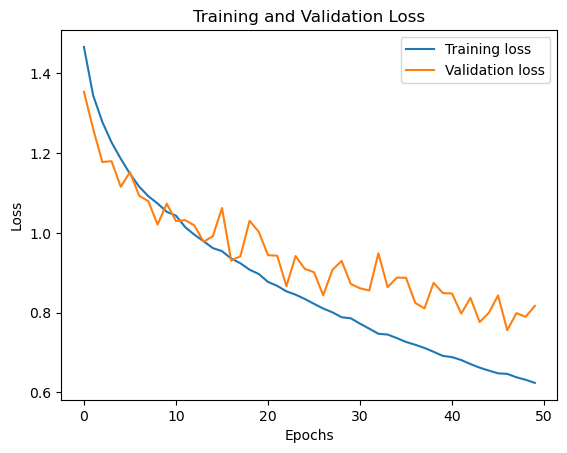

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
def calculate_accuracy(model, loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            # 출력에서 가장 높은 값을 가진 인덱스를 예측값으로 선택합니다 (다중 클래스 분류)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

test_accuracy = calculate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 73.28%
